# Machine Learning to detect pants

In this notebook, we will be training our pants model to use on predicitions and therefore, be able to detect the required pants

### Library Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import itertools

%matplotlib inline
from IPython.display import Image
from PIL import Image as ImagePL
from scipy.ndimage import zoom


# Libraries for TensorFlow
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras import backend as K

from tensorflow.keras.applications.resnet50 import preprocess_input

import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight
from sklearn.model_selection import KFold

### Load data

Dataset extracted from: https://www.kaggle.com/agrigorev/clothing-dataset-full

References from 

https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18/notebook

https://www.kaggle.com/marissafernandes/clothes-image-classifier/notebook

https://www.kaggle.com/viratkothari/image-classification-transfer-learning-resnet50

In [2]:
originalCSV = pd.read_csv('Data/images.csv')
originalCSV.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


Deleting unnecessary or wrong images

In [3]:
def imageCleaning(path):
    extensions = []
    bad_list = []
    for filee in os.listdir(path):
        file_path = os.path.join(path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:
            im = ImagePL.open(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])
        except:
            print("Error with " + file_path)
            bad_list.append(file_path)

#imageCleaning('Data\images_compressed')

In [4]:
typeOfData = originalCSV["label"].value_counts()
typeOfData

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

## Loading Data

In [5]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
EPOCHS = 20

### Data set generators

In [6]:
def createTrainSetAndValidationSet(data):
    generator = image.ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT
    )
    train_set = generator.flow_from_dataframe(
        dataframe=data,
        x_col="image",
        y_col="label",
        target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    val_set = generator.flow_from_dataframe(
        dataframe=data,
        x_col="image",
        y_col="label",
        target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    num_classes = len(train_set.class_indices)
    print("Total classes:", num_classes)
    return train_set, val_set, num_classes

### Checkpoint generator

In [7]:
def checkPointCreation(checkpoint_path):
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    return cp_callback

### Weights generator

In [8]:
def generateWeights(labels):
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(labels),y=labels)
    leng = max(labels)
    class_weight_dict = {i : class_weights[i] for i in range(leng+1)}
    print(class_weight_dict)
    return class_weight_dict

### Model generator

It would be interesting to use a pretrained model so that the training process is slowed down, and potentially, we will get better results. To avoid retraining it, we can use a common model like resNet. Therefore we can make use of pythorch pretrained models. We will split the data into the test and train data set so that we can use it for our pretrained model

https://keras.io/api/layers/

In [9]:
def generateModel(classesAmount):
    input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

    resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
    last_layer=resNet.output #We take output layers of resnet
    flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer
    
    # Add dense layer to the final output layer
    output_layer = layers.Dense(classesAmount,activation='softmax')(flatten)

    # Creating model with input and output layer
    model=models.Model(inputs=input_layer,outputs=output_layer)
    model.summary()

    #for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
    #    layer.trainable=False
    model.summary()
    return clone_model(model)

Once the model is prepared we can train it

### Getting weights

Sometimes it's good to retrive the existing weights

In [10]:
def load_weights(cp_path):
    print("Getting weights")
    current_Epoch = 0
    filepath = ''
    if os.path.exists(cp_path):
        for filename in os.listdir(cp_path):
            f = os.path.join(cp_path, filename)
            # checking if it is a file
            if os.path.isfile(f):
                try:
                    lsp = filename.split('-')[1]
                    num = int(lsp.split('.')[0])
                    if(current_Epoch <= num):
                        current_Epoch = num
                        file = filename.split('.index')[0]
                        filepath = os.path.join(cp_path, file)
                        print(filepath)
                except:
                    print("not this")
        print("Starting from epoch " + str(current_Epoch))
    return current_Epoch, filepath

### Confusion matrix visualizer

In [11]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    f = plt.figure()
    f.set_figwidth(100)
    f.set_figheight(100)

# Frist training pass

We are going to first, try out with the original data, as intended and see the results from there

## Original data

In [12]:
imagesPath = 'Data/images_compressed'
newCSV = originalCSV.copy()
newCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
newCSV = newCSV[['image', 'label']]

In [13]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(newCSV)

C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 4319 validated image filenames belonging to 20 classes.
Found 1079 validated image filenames belonging to 20 classes.
Total classes: 20


C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [14]:
cp_path = "checkPoints/modelTraining_original_unbalanced/cp-{epoch:04d}.ckpt"
cp_callback_original_unbalanced= checkPointCreation(cp_path)

In [15]:
originalModel_unbalanced = generateModel(num_classes)
originalModel_unbalanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [16]:
currentEpoch, file = load_weights("checkPoints/modelTraining_original_unbalanced")
if(currentEpoch != 0):
    originalModel_unbalanced.load_weights(file)
originalModel_unbalanced.fit(train_set,epochs=EPOCHS,initial_epoch = currentEpoch,verbose=True,validation_data=val_set, callbacks=[cp_callback_original_unbalanced])

Getting weights
not this
checkPoints/modelTraining_original_unbalanced\cp-0001.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0001.ckpt
checkPoints/modelTraining_original_unbalanced\cp-0002.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0002.ckpt
checkPoints/modelTraining_original_unbalanced\cp-0003.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0003.ckpt
checkPoints/modelTraining_original_unbalanced\cp-0004.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0004.ckpt
checkPoints/modelTraining_original_unbalanced\cp-0005.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0005.ckpt
checkPoints/modelTraining_original_unbalanced\cp-0006.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0006.ckpt
checkPoints/modelTraining_original_unbalanced\cp-0007.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0007.ckpt
checkPoin

In [17]:
if(currentEpoch < EPOCHS):
    originalModel_unbalanced.save('saved_model/pantsModel_original_unbalanced')

### Visualizing

In [18]:
originalModel_unbalanced = models.load_model('saved_model/pantsModel_original_unbalanced')
print("Model loaded")
predictions = originalModel_unbalanced.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
originalModel_unbalanced.evaluate(train_set)

Model loaded
135/135 [==============================] - 21s 148ms/step - loss: 2.1622 - accuracy: 0.7103


[2.1621718406677246, 0.7103496193885803]

Confusion matrix, without normalization
[[  1   0   1   4   2   0  10   3   1   5  17   3   5   7   5   0   1  23
    1   8]
 [  0   0   0   2   1   0   1   0   0   1   0   0   5   2   1   0   0   2
    0   1]
 [  0   0   3   1   4   1   6   5   0   1   4   2   3   6   4   0   0  11
    0   1]
 [  3   1   5  16  12   6  17   9   3  13  36  16  23  15  15   0   5  49
    2  21]
 [  2   1   2   9   8   2  14   3   1   6   8   5   8  10   5   0   2  22
    0   5]
 [  0   0   0   4   4   1  10   4   0   9   6   1   9   5   8   0   1  19
    1  11]
 [  7   2   7  34  25  12  81  20   4  29  66  20  43  52  32   0  14 129
    2  35]
 [  1   2   2  10   5   1  21   4   1   1  21   7  19  15   8   0  10  50
    1  11]
 [  1   0   0   1   1   1   3   1   1   3   6   3   3   1   0   0   1   9
    1   4]
 [  0   0   7  10  12   3  27   7   1  11  30  15  20  23  10   0   7  57
    0  22]
 [  7   0   8  16  37  14  54  18   9  30  69  30  49  40  29   0  10 107
    1  27]
 [  1   0   1   7   3   2

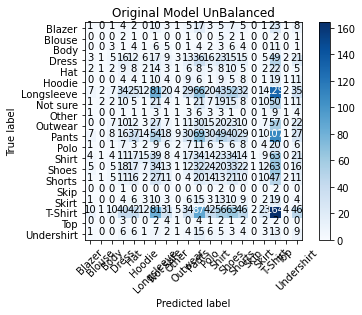

<Figure size 7200x7200 with 0 Axes>

In [19]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Original Model UnBalanced')

### Conclusions

We can see the next results

## Original data Balanced


In [20]:
cp_path = "checkPoints/modelTraining_original_balanced"
cp_file = "/cp-{epoch:04d}.ckpt"
cp_callback_original_balanced= checkPointCreation(cp_path+cp_file)
class_weight_dict_org = generateWeights(train_set.labels)

{0: 2.2262886597938145, 1: 13.496875, 2: 4.1528846153846155, 3: 0.8088014981273408, 4: 1.9110619469026549, 5: 2.3220430107526884, 6: 0.3517100977198697, 7: 1.1365789473684211, 8: 5.39875, 9: 0.8242366412213741, 10: 0.3890990990990991, 11: 2.0764423076923078, 12: 0.6484984984984985, 13: 0.6446268656716417, 14: 0.9555309734513274, 15: 43.19, 16: 1.9995370370370371, 17: 0.2702753441802253, 18: 8.997916666666667, 19: 2.511046511627907}


In [21]:
originalModel_balanced = generateModel(num_classes)
originalModel_balanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [22]:
currentEpoch, file = load_weights("checkPoints/modelTraining_original_balanced")
if(currentEpoch != 0):
    originalModel_balanced.load_weights(file)
originalModel_balanced.fit(train_set,epochs=EPOCHS, initial_epoch = currentEpoch,verbose=True,validation_data=val_set, callbacks=[cp_callback_original_balanced], class_weight = class_weight_dict_org)

Getting weights
not this
checkPoints/modelTraining_original_balanced\cp-0001.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0001.ckpt
checkPoints/modelTraining_original_balanced\cp-0002.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0002.ckpt
Starting from epoch 2
Epoch 3/20
135/135 [==============================] - ETA: 0s - loss: 3.6750 - accuracy: 0.0632
Epoch 3: saving model to checkPoints/modelTraining_original_balanced\cp-0003.ckpt
135/135 [==============================] - 88s 614ms/step - loss: 3.6750 - accuracy: 0.0632 - val_loss: 4.6331 - val_accuracy: 0.0639
Epoch 4/20
135/135 [==============================] - ETA: 0s - loss: 3.1343 - accuracy: 0.1132
Epoch 4: saving model to checkPoints/modelTraining_original_balanced\cp-0004.ckpt
135/135 [==============================] - 71s 525ms/step - loss: 3.1343 - accuracy: 0.1132 - val_loss: 3.0061 - val_accuracy: 0.0519
Epoch 5/20
135/135 [==============================] - ETA: 0s

In [23]:
if(currentEpoch < EPOCHS):
    originalModel_balanced.save('saved_model/pantsModel_original_balanced')

INFO:tensorflow:Assets written to: saved_model/pantsModel_original_balanced\assets


### Visualizing

In [24]:
originalModel_balanced = models.load_model('saved_model/pantsModel_original_balanced')
predictions = originalModel_balanced.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
originalModel_balanced.evaluate(train_set)

135/135 [==============================] - 20s 139ms/step - loss: 0.4169 - accuracy: 0.8875


[0.4169022738933563, 0.8874739408493042]

Confusion matrix, without normalization
[[  2   0   0   9   2   3  11   6   1   2  13   5   7  11   3   0   2  16
    0   4]
 [  0   0   0   2   0   0   3   1   0   0   4   0   3   1   0   0   1   1
    0   0]
 [  2   1   2   3   2   2   2   2   0   6   7   0   4   5   4   0   1   8
    0   1]
 [  4   0   0  26   7  11  29   6   3  11  42  15  19  17  18   0   9  37
    5   8]
 [  2   1   2   9   0   7  14   4   1  10   6   2   8  10   7   1   4  21
    1   3]
 [  4   1   0   2   6   2  16   4   0   1  17   2   9   4   8   0   3  11
    0   3]
 [ 16   6   9  44  17  25  85  21   1  28  67  13  41  54  36   0  14 108
   10  19]
 [  6   1   3  17   2   6  25   8   4   6  23   6  17  14  11   0   5  31
    0   5]
 [  0   0   0   1   2   0   6   4   0   3   2   2   1   3   2   1   1  10
    1   1]
 [  5   1   2  12   8   5  28  18   3  14  31  11  23  20  20   0   7  49
    0   5]
 [ 12   4  10  42  19  14  77  17   8  31  64  16  39  42  34   1  18  88
    2  17]
 [  3   0   2   6   4   2

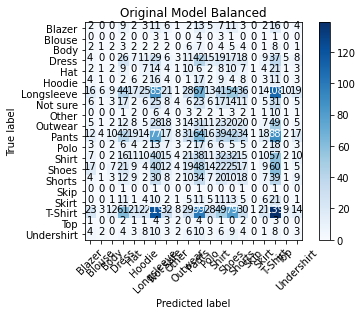

<Figure size 7200x7200 with 0 Axes>

In [25]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Original Model Balanced')

### Conclusions

Fuck, i cant see shit

# Simplifying Dataset

## Data cleaning

Since most of the data has been categorized, and we are mostly interested on some of the labels, and not all, to simplify and improve the training process, we are going to remove some of the categories. And transform them into a single type. We will transform those labels into, Top, Shorts, Pants, and remove some

The label Top will contain:
T-Shirt

The label Bottom will contain:
Pants

The other Shorts will contain:
Shorts

The removed ones will be:
Skirt
Dress
OutWear
Hat
Blazer
Hoodie
Skip
Blouse
Top
Polo
Undershirt
LongSleeve
Shirt

In [26]:
imagesPath = 'Data/images_compressed'
dataCSV = originalCSV.copy()
dataCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
dataCSV.dropna()

dataCSV.loc[dataCSV['label'] == 'T-Shirt','label'] = 'Top'

dataCSV.loc[dataCSV['label'] == 'Pants','label'] = 'Bottom_Long'

dataCSV.loc[dataCSV['label'] == 'Shorts','label'] = 'Bottom_Short'

newColumns = ['Top','Bottom_Long', 'Bottom_Short']
finalData = dataCSV.loc[dataCSV["label"].str.contains("Top|Bottom_Long|Bottom_Short")]
data_df = finalData[['image', 'label']]

Now we can check our new data

In [27]:
typeOfData = data_df["label"].value_counts()
data_df.head()

,image,label
1,Data/images_compressed/ea7b6656-3f84-4eb3-9099...,Top
3,Data/images_compressed/ea2ffd4d-9b25-4ca8-9dc2...,Top
5,Data/images_compressed/5d3a1404-697f-479f-9090...,Bottom_Short
7,Data/images_compressed/4c8f245e-a039-46fd-a6b9...,Top
8,Data/images_compressed/c995c900-693d-4dd6-8995...,Bottom_Long


In [28]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(data_df)

Found 1644 validated image filenames belonging to 3 classes.
Found 410 validated image filenames belonging to 3 classes.
Total classes: 3


## Unbalanced data

We will first try with an unbalanced weighting on the data

In [29]:
cp_path = "checkPoints/modelTraining_unbalanced/cp-{epoch:04d}.ckpt"
cp_callback_unbalanced= checkPointCreation(cp_path)

In [30]:
unbalancedModel = generateModel(num_classes)
unbalancedModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [31]:
currentEpoch, file = load_weights("checkPoints/modelTraining_unbalanced")
if(currentEpoch != 0):
    unbalancedModel.load_weights(file)
unbalancedModel.fit(train_set,epochs=EPOCHS, initial_epoch = currentEpoch, verbose=True,validation_data=val_set, callbacks=[cp_callback_unbalanced]) 

Getting weights
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 14.9389 - accuracy: 0.4410
Epoch 1: saving model to checkPoints/modelTraining_unbalanced\cp-0001.ckpt
52/52 [==============================] - 34s 584ms/step - loss: 14.9389 - accuracy: 0.4410 - val_loss: 2335.3481 - val_accuracy: 0.4927
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 10.7149 - accuracy: 0.4891
Epoch 2: saving model to checkPoints/modelTraining_unbalanced\cp-0002.ckpt
52/52 [==============================] - 29s 549ms/step - loss: 10.7149 - accuracy: 0.4891 - val_loss: 36973.3203 - val_accuracy: 0.5049
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 6.7767 - accuracy: 0.5170
Epoch 3: saving model to checkPoints/modelTraining_unbalanced\cp-0003.ckpt
52/52 [==============================] - 30s 580ms/step - loss: 6.7767 - accuracy: 0.5170 - val_loss: 608.5428 - val_accuracy: 0.3463
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 

In [32]:
if(currentEpoch < EPOCHS):
    unbalancedModel.save('saved_model/pantsModel_unbalanced')

INFO:tensorflow:Assets written to: saved_model/pantsModel_unbalanced\assets


### Visualizing

In [33]:
unbalancedModel = models.load_model('saved_model/pantsModel_unbalanced')
predictions = unbalancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
unbalancedModel.evaluate(train_set)

52/52 [==============================] - 10s 166ms/step - loss: 15.1489 - accuracy: 0.8893


[15.1488676071167, 0.8892943859100342]

Confusion matrix, without normalization
[[233  79 253]
 [100  25 107]
 [360 110 377]]


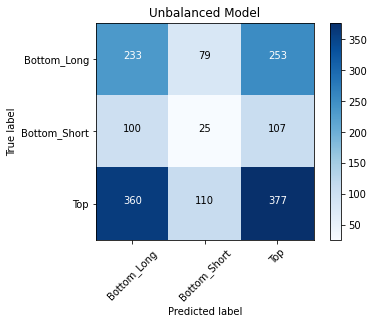

<Figure size 7200x7200 with 0 Axes>

In [34]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Unbalanced Model')

### Conclusions

In this model we can see that Top is being classified accordingly, however some of those are set to bottom_long. The amount of bottom long classified as top and the other way around is too big to aknowladge as good results, altought the accuracy in theoru is high, up to 93% I dont understand why

## Balanced Model

We will also train a blanaced Model, having some balanced weights to use

In [35]:
cp_path = "checkPoints/modelTraining_balanced/cp-{epoch:04d}.ckpt"
cp_callback_balanced= checkPointCreation(cp_path)
class_weight_dict = generateWeights(train_set.labels)

{0: 0.9699115044247788, 1: 2.3620689655172415, 2: 0.6469893742621016}


In [36]:
balancedModel = generateModel(num_classes)
balancedModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [37]:
currentEpoch, file = load_weights("checkPoints/modelTraining_balanced")
if(currentEpoch != 0):
    balancedModel.load_weights(file)    
balancedModel.fit(train_set,epochs=EPOCHS,initial_epoch = currentEpoch, verbose=True,validation_data=val_set, callbacks=[cp_callback_balanced], class_weight = class_weight_dict)

Getting weights
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 11.6515 - accuracy: 0.3917
Epoch 1: saving model to checkPoints/modelTraining_balanced\cp-0001.ckpt
52/52 [==============================] - 41s 679ms/step - loss: 11.6515 - accuracy: 0.3917 - val_loss: 28.8953 - val_accuracy: 0.3098
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 8.0286 - accuracy: 0.4155
Epoch 2: saving model to checkPoints/modelTraining_balanced\cp-0002.ckpt
52/52 [==============================] - 37s 702ms/step - loss: 8.0286 - accuracy: 0.4155 - val_loss: 7.1818 - val_accuracy: 0.4341
Epoch 3/20
16/52 [========>.....................] - ETA: 21s - loss: 10.5752 - accuracy: 0.4590

ResourceExhaustedError: Graph execution error:

Detected at node 'model_3/conv5_block3_3_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\pauso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\pauso\AppData\Local\Temp\ipykernel_12112\3020918762.py", line 4, in <cell line: 4>
      balancedModel.fit(train_set,epochs=EPOCHS,initial_epoch = currentEpoch, verbose=True,validation_data=val_set, callbacks=[cp_callback_balanced], class_weight = class_weight_dict)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model_3/conv5_block3_3_conv/Conv2D'
OOM when allocating tensor with shape[2048,512,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/conv5_block3_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_352968]

In [ ]:
if(currentEpoch < EPOCHS):
    balancedModel.save('saved_model/pantsModel_balanced')

### Visualizing

In [ ]:
balancedModel = models.load_model('saved_model/pantsModel_balanced')
predictions = balancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
balancedModel.evaluate(train_set)

In [ ]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Balanced Model')

### Conclusions

When using a balanced model, we can see that the accuracy goes lower, and the errors increase. However we can still see how there are almost no objects classified correctly as bottom_short, bottom_short

# First conclusions

It is clear that by just using transfer learning as show before, the results are bad, therefore i shall find a better way. Possible options are using a differential learning rate.

Instead of unfreezing specific layers, it’s probably a better idea to use a differential learning rate, where the learning rate is determined on a per-layer basis. The bottom layers will then have a very low learning rate, as these generalise quite well, responding principally to edges, blobs and other trivial geometries, whereas the layers responding to more complex features will have a larger learning rate. In the past, the 2:4:6 rule (negative powers of 10) has worked quite well for me — using a learning rate of 10^-6 for the bottommost few layers, 10^-4 for the other transfer layers and 10^-2 for any additional layers we added. I have also heard others using 2:3:4:5:6 or 2:3:4 with different architectures. For ResNets and their derivatives, I have always felt more comfortable with 2:4:6 than 2:3:4, but I have absolutely no empirical evidence to back this up with. (https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625)

Also, redoing it from scratch,

When transferring to a task with a relatively large data set, you might want to train the network from scratch (which would make it not transfer learning at all). At the same time — given that such a network would be initialised with random values, you have nothing to lose by using the pretrained weights! Unfreeze the entire network, remove the output layer and replace it with one matching the number of destination task classes, and fine-tune the whole network.

Same reference

# HeatMap visualization

In [ ]:
modelTest = models.load_model('saved_model/pantsModel_unbalanced')

In [ ]:
def gradCAM(orig, model, intensity=0.5, res=224):
    img = image.load_img(orig, target_size=(res, res))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    print((preds)) # prints the class of image
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_out')
        iterate = models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))
    img = cv2.imread(orig)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    img = img
    plt.imshow(heatmap)

gradCAM(r'Data\images_compressed\1b065c3c-0679-40af-9924-8de9986fdf66.jpg', modelTest)

# Improvement options

Let's make a list of some options to improve this overffiting results that we are getting:
- Cross-validation will allow us to know if we are having good data
- Unfreezing some of the layers might improve accuracy
- Unfreezing some of the layers at the end might improve accuracy
- Trying a different model than ResNet50 might improve accuracy
- Data augmentation might improve results

## Trying cross-validation to learn overfitting results

Trying to improve our model, we can test out

## Trying diferent model methods for overfitting improvement

In [ ]:
np.max(heatma p)

## Including label with a modified dataset